# Compare REM and HAND approaches

In [16]:
import os

import geopandas as gpd
import numpy as np
import rioxarray
import matplotlib.pyplot as plt
import whitebox

from valleys.subbasins import setup_wbt

In [14]:
wbt = setup_wbt("~/opt/WBT/", "../data/wb_outputs/")

## Get Data for single catchment

In [7]:
filled_dem = rioxarray.open_rasterio("../toy_data/filled_dem.tif")
subbasins = rioxarray.open_rasterio("../toy_data/subbasins.tif")
streams = rioxarray.open_rasterio("../toy_data/streams.tif")

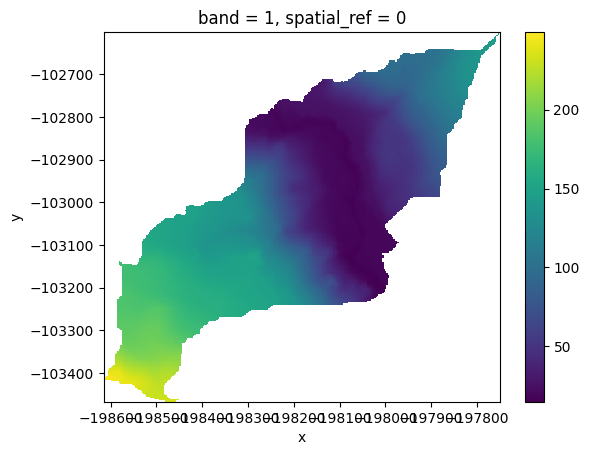

In [8]:
basin_id = 11
dem = filled_dem.where(subbasins == basin_id)
dem = dem.dropna(dim="x", how="all")
dem = dem.dropna(dim="y", how="all")
dem.plot()

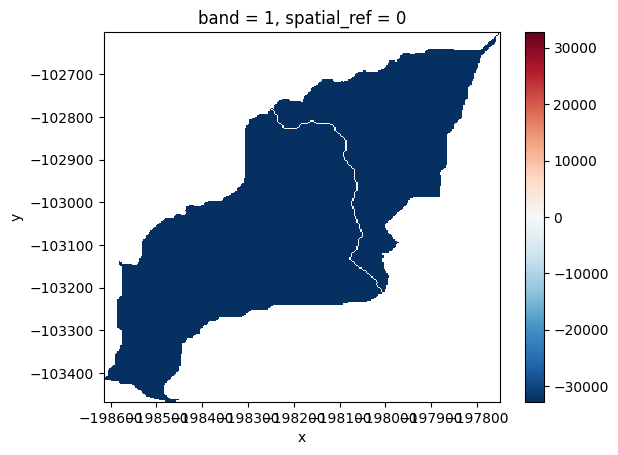

In [19]:
stream = streams.where(subbasins == basin_id)
stream = stream.dropna(dim="x", how="all")
stream = stream.dropna(dim="y", how="all")
stream.plot()

In [10]:
# convert stream to vector
def vectorize_streams(wbt, streams, dem):
    # write streams and dem to temp files
    streams.rio.to_raster(os.path.join(wbt.work_dir, "temp_stream.tif"))
    dem.rio.to_raster(os.path.join(wbt.work_dir, "temp_dem.tif"))

    wbt.d8_pointer("temp_dem.tif", "temp_d8_pntr.tif")

    wbt.raster_streams_to_vector("temp_stream.tif", "temp_d8_pntr.tif", "stream.shp")

    os.remove(os.path.join(wbt.work_dir, "temp_stream.tif"))
    os.remove(os.path.join(wbt.work_dir, "temp_dem.tif"))
    os.remove(os.path.join(wbt.work_dir, "temp_d8_pntr.tif"))
    
    return gpd.read_file(os.path.join(wbt.work_dir, "stream.shp"))

In [20]:
stream_flowline = vectorize_streams(wbt, stream, dem)

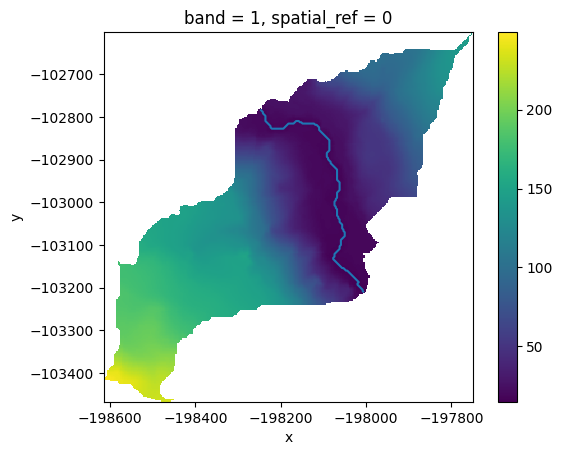

In [21]:
fig, ax = plt.subplots()
stream_flowline.plot(ax = ax)
dem.plot(ax = ax)

## HAND

In [24]:
def hand_wbt(dem_raster, stream_raster):
    # need to do the temp file dance
    stream_raster.rio.to_raster(os.path.join(wbt.work_dir, "temp_stream.tif"))
    dem_raster.rio.to_raster(os.path.join(wbt.work_dir, "temp_dem.tif"))

    wbt.elevation_above_stream("temp_dem.tif", "temp_stream.tif", "hand.tif")
    os.remove(os.path.join(wbt.work_dir, "temp_stream.tif"))
    os.remove(os.path.join(wbt.work_dir, "temp_dem.tif"))

    return rioxarray.open_rasterio(os.path.join(wbt.work_dir, "hand.tif"))


hand = hand_wbt(dem, stream)

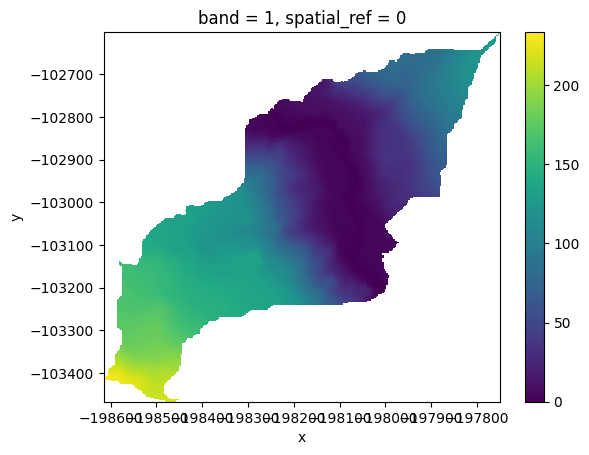

In [26]:
masked = hand.where(hand != -32768)
masked.plot()

## REM